I've already transformed raw column timestamp in a timestamp and adjusted putting the real NaN.  
Now I want to go deep into the information that I can extract from the timestamp

Starting point: https://www.shaped.ai/blog/decoding-timestamps-time-based-feature-engineering-for-search-recs

In [1]:
import pandas as pd
from src.utils import load_data
from src.config import *

df = load_data(DEVELOPMENT_PATH)


I want to see if there are correlation between these new features and the labels

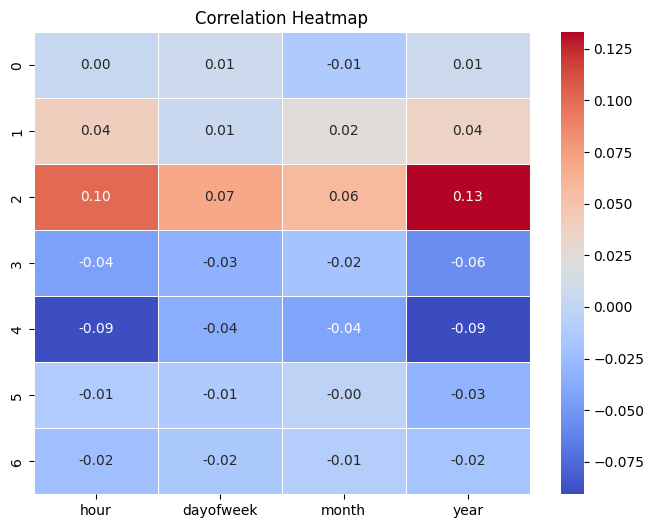

In [3]:
time_cols = ["hour", "dayofweek", "month", "year"]

corrs = {}

for c in sorted(df["y"].unique()):
    y_bin = (df["y"] == c).astype(int)
    corrs[c] = df[time_cols].apply(lambda x: x.corr(y_bin, method="spearman"))
corr_df = pd.DataFrame(corrs).T

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

It seems that relations are very weak, but I still think that they can be valuable.  
Other ways to see and test correlation between label and this time cols: https://towardsdatascience.com/contingency-tables-chi-squared-and-cramers-v-ada4f93ec3fd/ 

hour    0    1    2    3    4    5    6    7    8    9   ...   15   16   17  \
y                                                        ...                  
0     7740  621  596  612  566  595  584  499  555  559  ...  672  669  661   
1     3135  342  270  222  197  200  237  261  323  296  ...  347  324  330   
2     2345  402  424  382  375  359  297  259  311  327  ...  327  353  409   
3     3603  232  258  245  221  218  198  207  281  337  ...  194  214  195   
4     3622  167  199  212  239  257  253  340  304  269  ...  117  106  133   
5     4349  274  316  366  330  292  230  210  240  263  ...  363  389  385   
6     1100   80  103   96   78   63   69   74   86  122  ...   61   60   57   

hour   18   19   20   21   22   23   24  
y                                        
0     626  693  689  744  694  679  604  
1     362  311  366  327  370  371  350  
2     394  453  472  469  472  431  469  
3     197  239  249  218  217  217  236  
4     120  122  127  136  124  145  

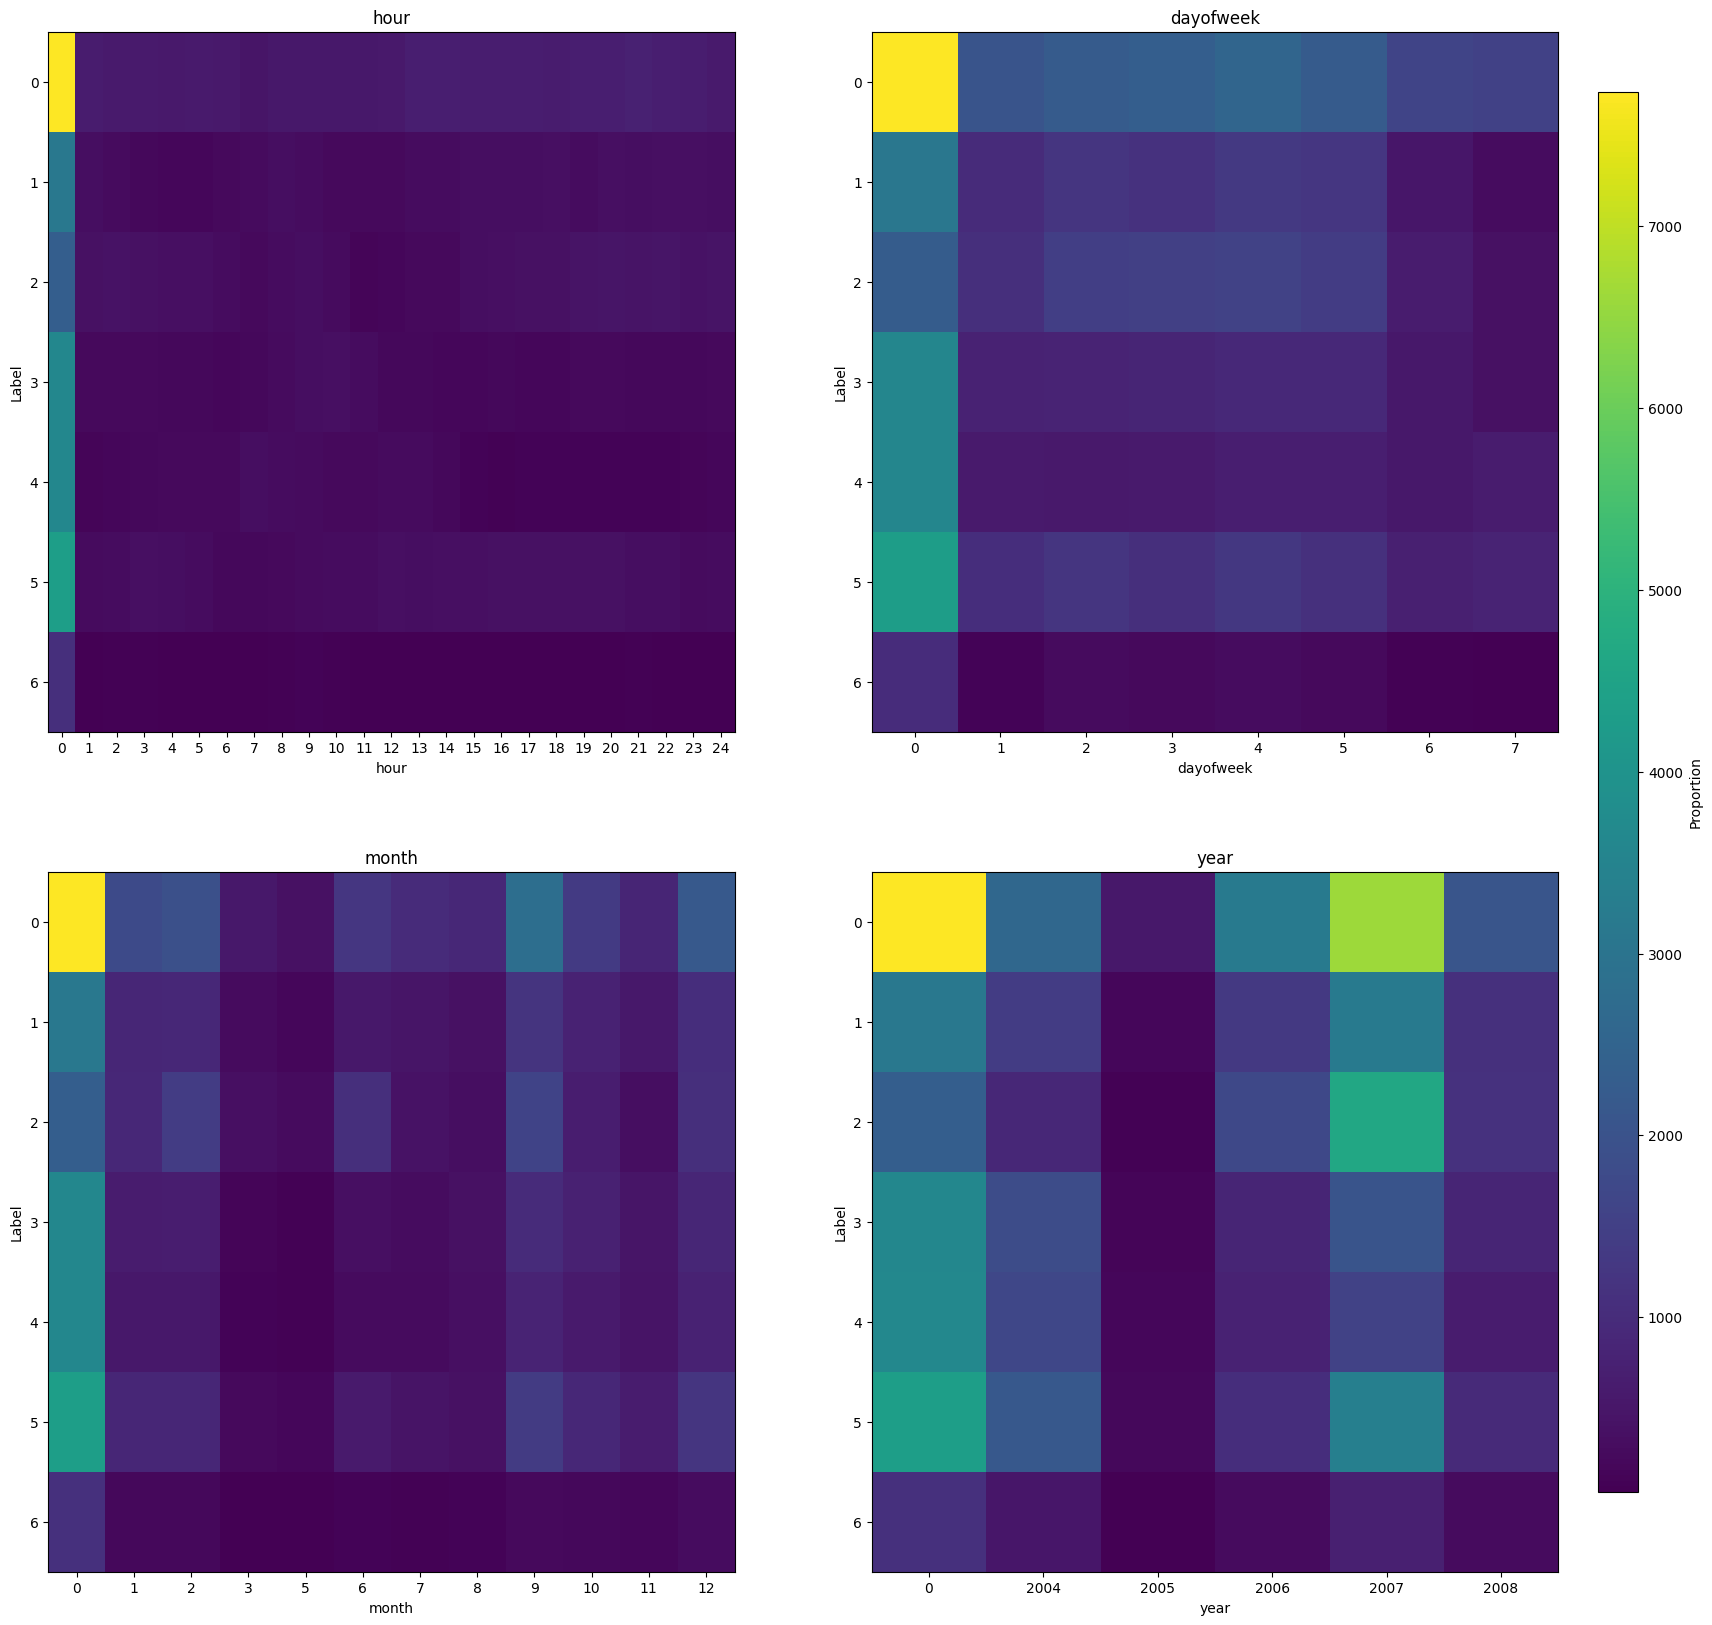

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, time_col in enumerate(time_cols):

    # creation of the contingency table: is a table that displays the multivariate frequency distribution 
    # of the variables
    # Intuitvely, they provide a basic picture of the interrelation between two variables 
    # (https://en.wikipedia.org/wiki/Contingency_table)
    ct = pd.crosstab(df["y"], df[time_col])

    # Pearson's chi-squared test: evaluate how likely it is that any observed difference
    # between the variables arose by chance (https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
    # In this test, H0: the two variables are independnt
    chi2, p, dof, expected = chi2_contingency(ct)

    print('='*50)
    print(ct)
    print(f'p-value: {p}')

    print('='*50)


    ax = axes[i // 2, i % 2]
    im = ax.imshow(ct, aspect="auto")

    ax.set_title(time_col)
    ax.set_xlabel(time_col)
    ax.set_ylabel("Label")

    ax.set_xticks(range(ct.shape[1]))
    ax.set_xticklabels(ct.columns)
    ax.set_yticks(range(ct.shape[0]))
    ax.set_yticklabels(ct.index)

# These lines are for the colorbar on the right 
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cax, label="Proportion")

plt.show()


Given the large sample size, the tests have extremely high statistical power, so even negligible effects result in p-values below machine precision. Therefore, p-values are not so informative about effect size, they only tells that they're not fully independent.

The cross-tab visualization is more interest, becuase it tells us that a relationship might exist, but probabily depending on the original dataset distributions.

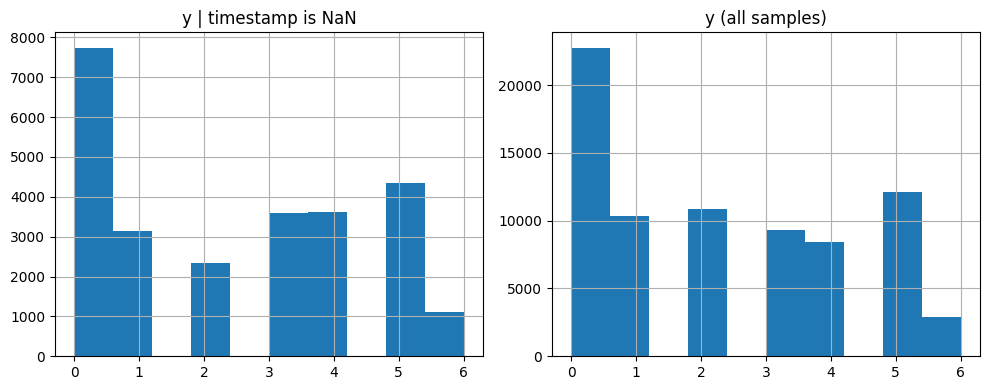

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

df[df["timestamp"].isna()]["y"].hist(ax=axes[0])
axes[0].set_title("y | timestamp is NaN")

df["y"].hist(ax=axes[1])
axes[1].set_title("y (all samples)")

plt.tight_layout()
plt.show()

The distributions seem comparable.

---

Let's continue with others features

- Encode time features cyclical 
- Encode other info (season , is_weekend) 

(NOTE: for this analysis, we dropped timestamp missing rows)

### 1. Month - Cyclical encoding and season

In [2]:
df = df[df['timestamp_missing'] == False]

In [28]:
monthly_rate = df.groupby("month")["y"].mean().reset_index()
monthly_rate

,month,y
0,1,2.137960
1,2,2.070893
2,3,1.955857
3,5,2.006531
4,6,2.036854
5,7,2.032814
6,8,2.203289
7,9,2.105030
8,10,2.382959
9,11,2.511540


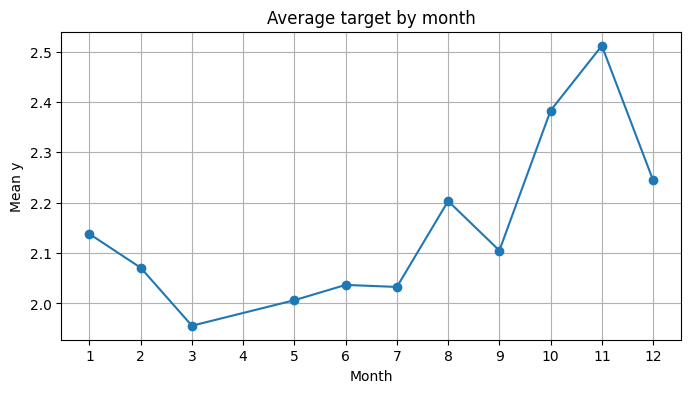

In [29]:
plt.figure(figsize=(8,4))
plt.plot(monthly_rate["month"], monthly_rate["y"], marker="o")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Mean y")
plt.title("Average target by month")
plt.grid(True)
plt.show()


This chart show that a cyclical encoding of the month might be a good solution, since the effect of the month on the label seems continuous and cyclical.

In [30]:
monthly_rate_by_year = df.groupby(["year", "month"])["y"].mean().reset_index()
monthly_rate_by_year.head()

,year,month,y
0,2004,8,2.463320
1,2004,9,2.588399
2,2004,10,2.704090
3,2004,11,2.731396
4,2004,12,2.607549


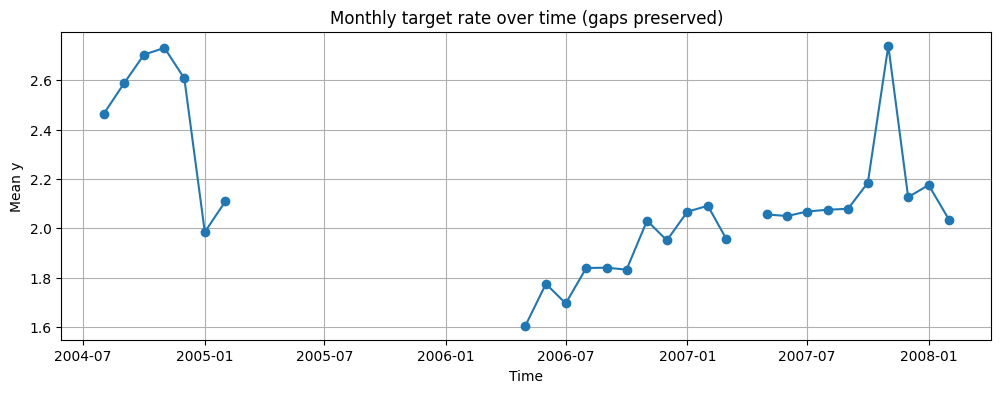

In [32]:
monthly_rate_by_year = (
    df.groupby(["year", "month"])["y"]
    .mean()
    .reset_index()
)

monthly_rate_by_year["date"] = pd.to_datetime(
    dict(year=monthly_rate_by_year["year"], month=monthly_rate_by_year["month"], day=1)
)

full_idx = pd.date_range(
    monthly_rate_by_year["date"].min(),
    monthly_rate_by_year["date"].max(),
    freq="MS"
)

ts = (
    monthly_rate_by_year.set_index("date")["y"]
    .reindex(full_idx)
)

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, marker="o")
plt.xlabel("Time")
plt.ylabel("Mean y")
plt.title("Monthly target rate over time (gaps preserved)")
plt.grid(True)
plt.show()


Because several months are missing, the temporal evolution of the target is noisy and hard to interpret.  
In addition, months within the same season do not show similar behavior, while the month variable seems to affect the label in a continuous way.  
For this reason, season was not encoded (also because it would be partly redundant) and month was encoded using a cyclical representation.

---

### 2. Hour - Cyclical encoding

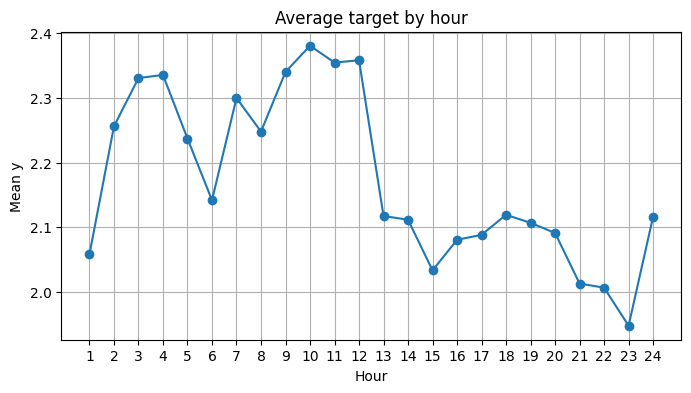

In [39]:
hourly_rate = df.groupby("hour")["y"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly_rate["hour"], hourly_rate["y"], marker="o")
plt.xticks(range(1, 25))
plt.xlabel("Hour")
plt.ylabel("Mean y")
plt.title("Average target by hour")
plt.grid(True)
plt.show()


Also year it's quite evident the cyclical pattern


In [5]:
hourly_by_y = df.groupby(["y", "hour"]).size().reset_index(name="count")

hourly_by_y["prop"] = (hourly_by_y["count"] / hourly_by_y.groupby("y")["count"].transform("sum"))



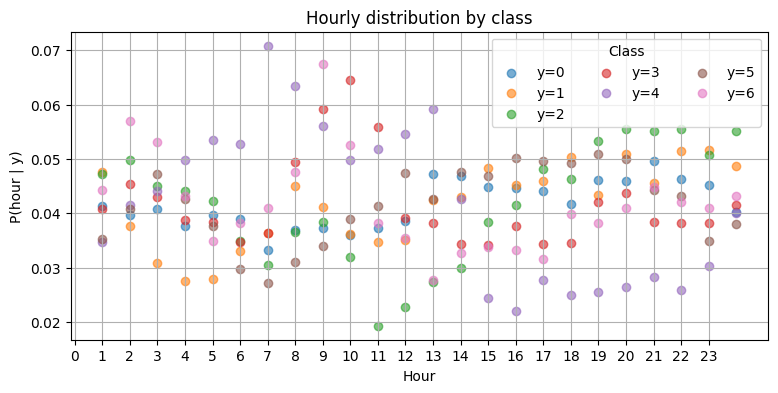

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))


for cl, df_c in hourly_by_y.groupby("y"):
    df_c = df_c.sort_values("hour")
    plt.scatter(
        df_c["hour"],
        df_c["prop"],
        marker="o",
        alpha=0.6,
        label=f"y={cl}"
    )

plt.xticks(range(0,24))
plt.xlabel("Hour")
plt.ylabel("P(hour | y)")
plt.title("Hourly distribution by class")
plt.grid(True)
plt.legend(title="Class", ncol=3)

plt.show()


---

### 3. Day

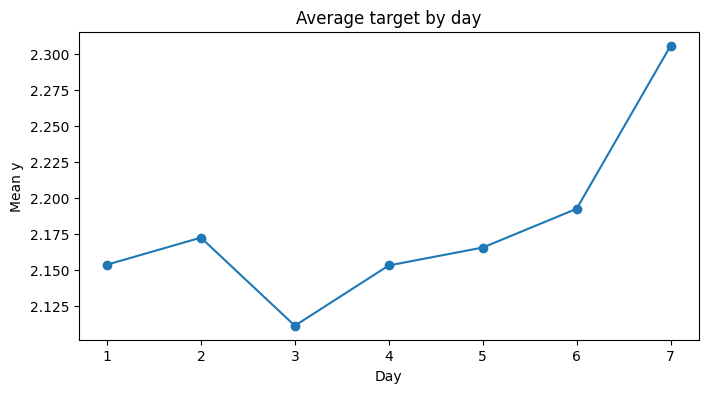

In [38]:
daily_rate = df.groupby("dayofweek")["y"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(daily_rate["dayofweek"], daily_rate["y"], marker="o")
plt.xticks(range(1, 8))
plt.xlabel("Day")
plt.ylabel("Mean y")
plt.title("Average target by day")
plt.show()


Here no clear cyclical pattern emerges, but a noticeable spike appears during weekends. Therefore, I encoded an is_weekend binary feature.

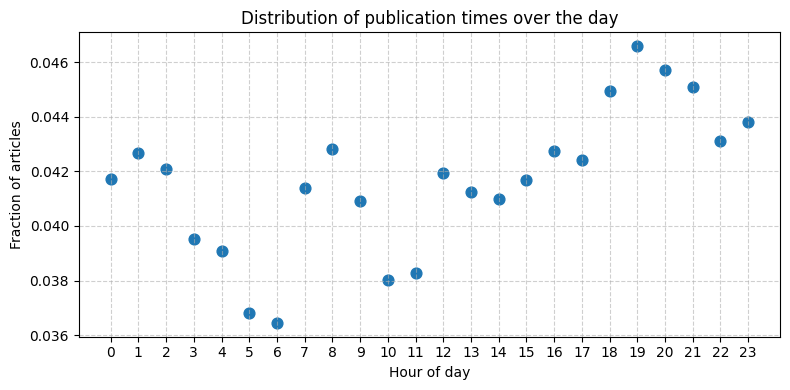

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

ts = pd.to_datetime(df["timestamp"], errors="coerce")
hours = ts.dt.hour.dropna()

hour_freq = hours.value_counts(normalize=True).sort_index()
hour_freq = hour_freq.reindex(range(24), fill_value=0)

plt.figure(figsize=(8,4))
plt.scatter(hour_freq.index, hour_freq.values, s=60)
plt.xticks(range(0,24))
plt.xlabel("Hour of day")
plt.ylabel("Fraction of articles")
plt.title("Distribution of publication times over the day")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))


for cl, df_c in hourly_by_y.groupby("y"):
    df_c = df_c.sort_values("hour")
    plt.plot(
        df_c["hour"],
        df_c["prop"],
        marker="o",
        alpha=0.6,
        label=f"y={cl}"
    )

plt.xticks(range(0,24))
plt.xlabel("Hour")
plt.ylabel("P(hour | y)")
plt.title("Hourly distribution by class")
plt.grid(True)
plt.legend(title="Class", ncol=3)

plt.show()


NameError: name 'hourly_by_y' is not defined

<Figure size 900x400 with 0 Axes>

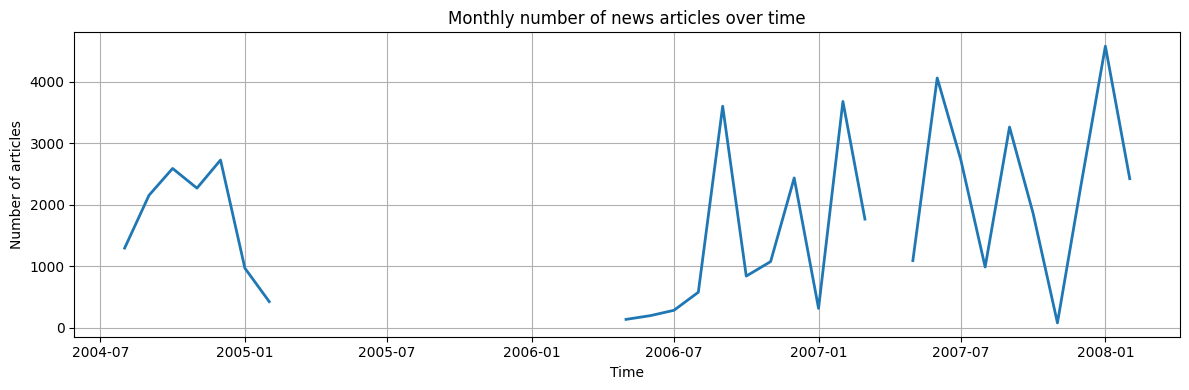

In [10]:
import matplotlib.pyplot as plt
monthly_rate_by_year = (
    df.groupby(["year", "month"])
    .count()
    .reset_index()
)

monthly_rate_by_year["date"] = pd.to_datetime(
    dict(year=monthly_rate_by_year["year"], month=monthly_rate_by_year["month"], day=1)
)

full_idx = pd.date_range(
    monthly_rate_by_year["date"].min(),
    monthly_rate_by_year["date"].max(),
    freq="MS"
)

ts = (
    monthly_rate_by_year.set_index("date")["y"]
    .reindex(full_idx)
)

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, linewidth=2)
plt.xlabel("Time")
plt.ylabel("Number of articles")
plt.title("Monthly number of news articles over time")
plt.grid(True)
plt.tight_layout()
plt.savefig("timestamp.pdf", bbox_inches="tight") 
plt.show()
